In [2]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import Video, widgets
from IPython.display import display

%matplotlib inline

In [3]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:

    def imshow(img):
        img = img.clip(0, 255).astype("uint8")
        if img.ndim == 3:
            if img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(img))

In [4]:
def resize_img(img, div=3):
    return cv2.resize(img, (img.shape[1]//div, img.shape[0]//div))

In [5]:
chessboard = cv2.imread("Chess_Data/frame1.jpg")
chessboard.shape

(1080, 1920, 3)

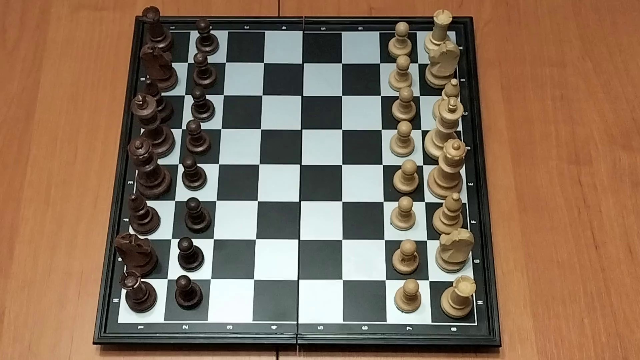

In [6]:
imshow(resize_img(chessboard))

## Calibrate camera

In [10]:
def find_closest_points_to_corners(points, corners):
    closest_points = []
    for corner in corners:
        distances = np.linalg.norm(points - corner, axis=1)
        closest_point_index = np.argmin(distances)
        closest_points.append(points[closest_point_index])
    return np.array(closest_points)

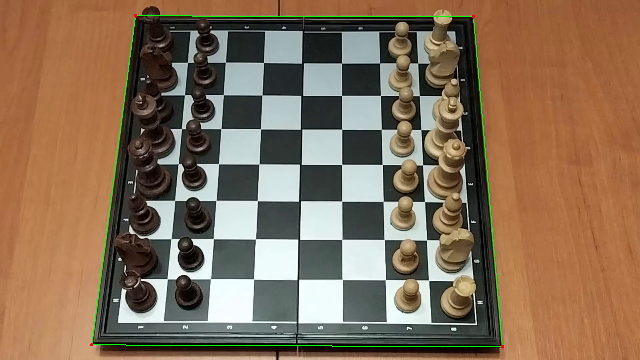

In [18]:
gray = cv2.cvtColor(chessboard, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(gray, 50, 150)

frame_with_boxes = chessboard.copy()
dst = cv2.cornerHarris(blurred, 5, 3, 0.02)
dst = cv2.dilate(dst, None)
corners = np.argwhere(dst > 0.01 * dst.max())

# Find corners closest to image corners
image_corners = np.array([[0, 0], [0, chessboard.shape[1]], [chessboard.shape[0], 0], [chessboard.shape[0], chessboard.shape[1]]])
closest_corners = find_closest_points_to_corners(corners, image_corners)

trapezoid_pts = np.array([[closest_corners[0][1], closest_corners[0][0]], [closest_corners[2][1], closest_corners[2][0]], [closest_corners[3][1], closest_corners[3][0]], [closest_corners[1][1], closest_corners[1][0]]], np.int32)
trapezoid_pts = trapezoid_pts.reshape((-1, 1, 2))
cv2.polylines(frame_with_boxes, [trapezoid_pts], isClosed=True, color=(0, 255, 0), thickness=2)

for corner in closest_corners:
    cv2.circle(frame_with_boxes, tuple(corner[::-1]), 5, (0, 0, 255), -1)

# Display the result
imshow(resize_img(frame_with_boxes))

In [12]:
closest_corners

array([[  47,  406],
       [  50, 1420],
       [1034,  275],
       [1040, 1507]], dtype=int64)

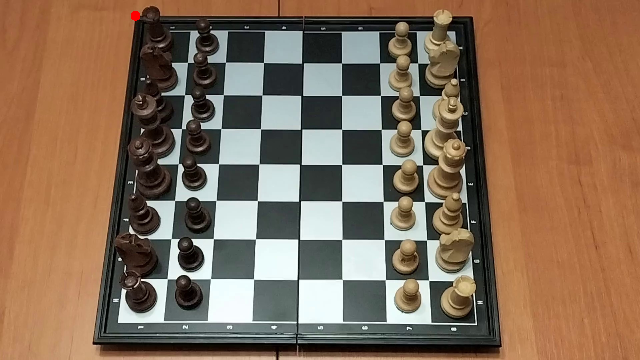

In [17]:
chessboard_copy = chessboard.copy()
cv2.circle(chessboard_copy, closest_corners[0][::-1], 15, (0, 0, 255), -1)
imshow(resize_img(chessboard_copy))

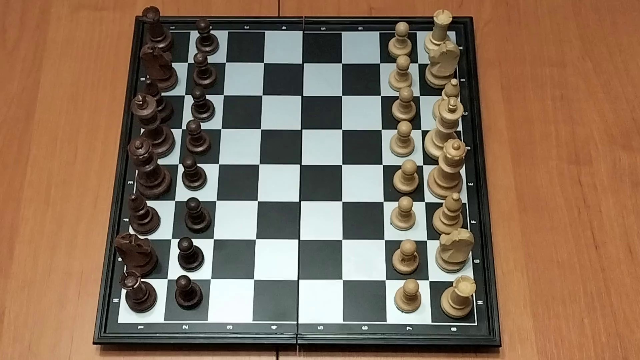

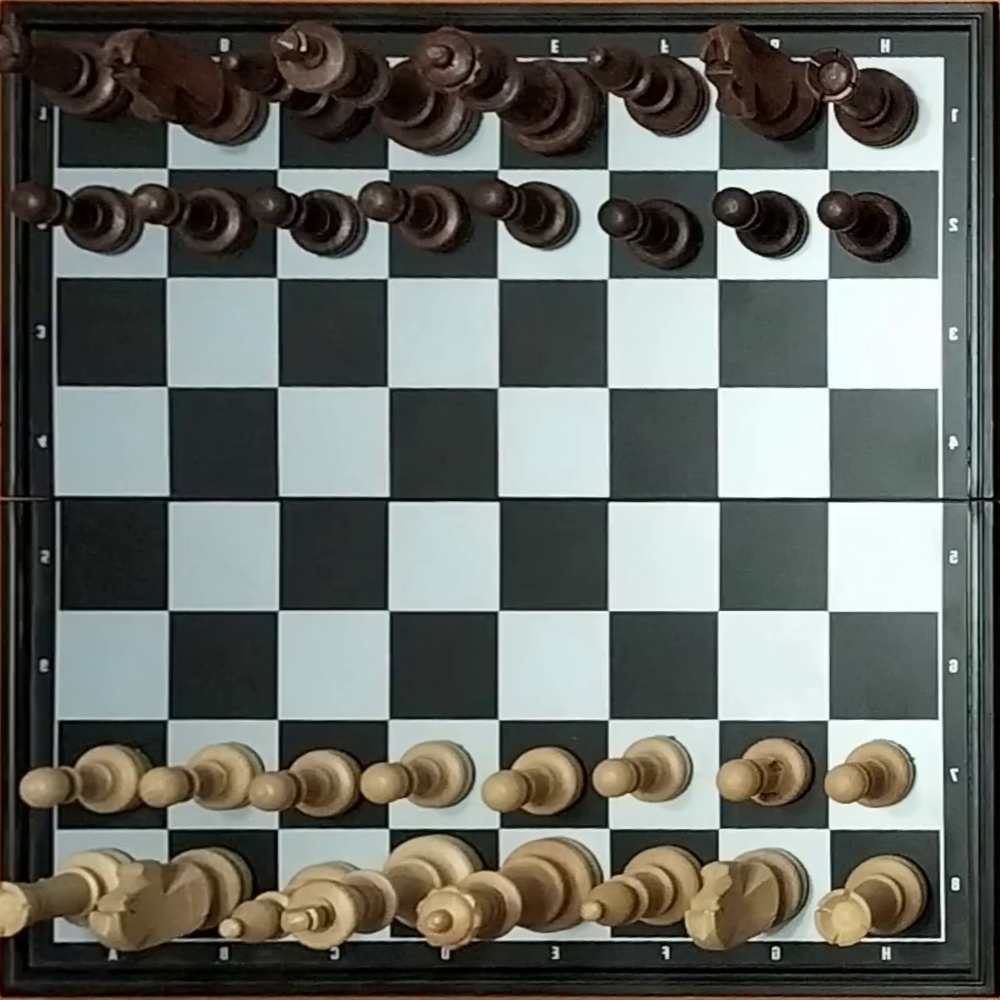

In [28]:
target_square_size = 1000  # Adjust the size as needed
target_points = np.array([[0, 0], [0, target_square_size - 1], [target_square_size - 1, 0], [target_square_size - 1, target_square_size - 1]], dtype=np.float32)

# Calculate the homography matrix
homography_matrix, _ = cv2.findHomography(closest_corners[:,::-1], target_points)

# Apply the perspective transformation
calibrated_image = cv2.warpPerspective(chessboard, homography_matrix, (target_square_size, target_square_size))

chessboard_copy = chessboard.copy()
imshow(resize_img(chessboard_copy))
imshow(calibrated_image)

In [27]:
calibrated_image.shape

(1000, 1000, 3)